In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('hackathon_data.csv').astype(float, errors='ignore')

In [3]:
df.columns = ['date_time', 'power_demand']

In [4]:
df['year'] = pd.to_datetime(df['date_time']).dt.year
df['month'] = pd.to_datetime(df['date_time']).dt.month
df['day'] = pd.to_datetime(df['date_time']).dt.day
df['hour'] = pd.to_datetime(df['date_time']).dt.hour

df['date'] = pd.to_datetime(df['date_time']).dt.date

In [5]:
df[['date', 'power_demand']]\
    .groupby('date')\
    .sum()\
    .plot(figsize=(20,8));

# Data cleaning

## NaN / small / huge  values

In [6]:
# There are some na values or zeros in datasets, lets find and fill them

In [7]:
len(df[df['power_demand'] == 0])/len(df)*100

0.0

In [8]:
len(df[df['power_demand'].isna()])/len(df)*100

0.6109979633401221

In [9]:
# We should delete those values and replace them with averages, since we cannot be sure
# Whether it is because of system error or correction
len(df[df['power_demand'] < 20])/len(df)*100

3.4726776899444234

In [10]:
# that's first thing to notice, and also I can't find any seasonality or possible
# causes of such things - and model cannot learn how to predict unpredictable
len(df[df['power_demand'] > 1200])/len(df)*100

4.5634989126307435

In [11]:
# Let's fill na values with average value for this month/day/hour across years

In [12]:
# first of all we need dates when there is no data
# nan, zezros, 5 and 15, and values more then 1200
df['month_day_hour'] = df['date_time'].str[5:]
month_day_hour_missing = df\
    [(df['power_demand'].isna())|(df['power_demand'] < 20)|(df['power_demand'] > 1200)]\
    ['month_day_hour'].unique()

In [13]:
# and values which will be used to replace zeros
missing_dates_avg = df[
    (df['month_day_hour'].isin(month_day_hour_missing)) &
    (~df['power_demand'].isna())
  ]\
    [['month_day_hour', 'power_demand']]\
    .groupby('month_day_hour')\
    .mean()

In [14]:
# But, some of the values we would like to use to replace NaN's are also bad
missing_dates_avg\
    .sort_values('power_demand')\
    .head(5)

,power_demand
month_day_hour,
09-07 02:00:00,-12065.073574
06-08 08:00:00,-10456.640633
07-11 03:00:00,12.333333
05-22 02:00:00,15.333333
06-13 02:00:00,15.333333


In [15]:
missing_dates_avg = missing_dates_avg\
    [missing_dates_avg['power_demand'] > 100]

In [16]:
# Now it looks much more legimate
missing_dates_avg\
    .sort_values('power_demand')\
    .head(5)

,power_demand
month_day_hour,
03-31 01:00:00,100.250000
03-23 02:00:00,100.750000
08-14 03:00:00,101.000000
05-22 03:00:00,101.666667
08-02 02:00:00,102.000000


In [17]:
len(missing_dates_avg)

2019

In [18]:
len(month_day_hour_missing)

2186

In [19]:
# We have a good aproximation for most of the values, for the rest two ones we will deal later

In [20]:
averages_dict = missing_dates_avg.to_dict('index')

In [21]:
from math import isnan

In [22]:
cleaned_power_demand = []
for row in df[['month_day_hour', 'power_demand']].to_dict('records'):
    if row['power_demand'] < 0 or row['power_demand'] > 1200:
        cleaned_power_demand.append(float(df['power_demand'].median()))
    elif not isnan(row['power_demand']):
        cleaned_power_demand.append(float(row['power_demand']))
    else:
        # remember, there are nan values for which we dont have calculated averages
        try:
            cleaned_power_demand.append(float(averages_dict[row['month_day_hour']]['power_demand']))
        except:
            # For this values we will just use median from all dataset
            cleaned_power_demand.append(float(df['power_demand'].median()))

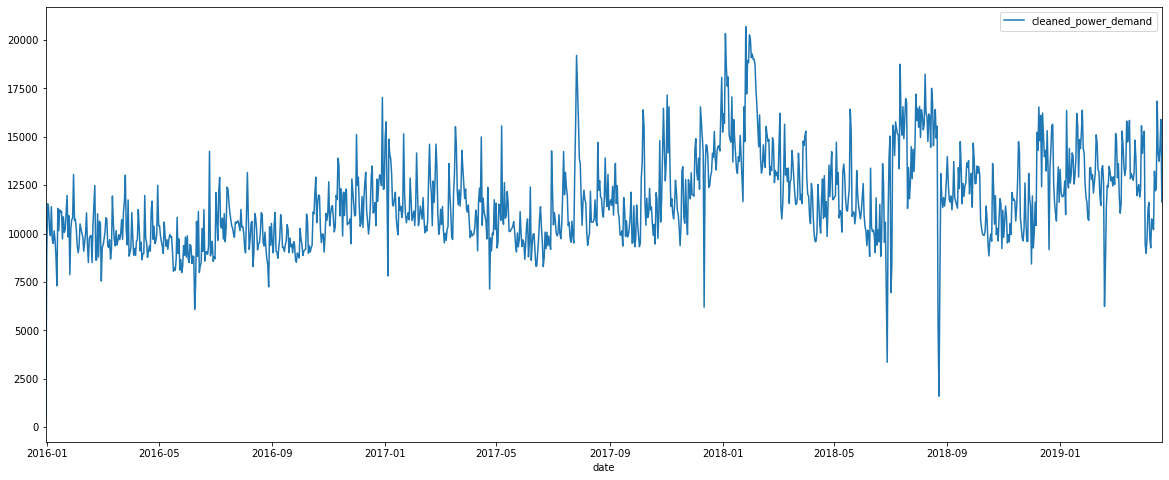

In [23]:
# And not it looks much better without big downfalls
pd.concat([df, pd.Series(cleaned_power_demand, name = 'cleaned_power_demand')], axis = 1)\
    [['date', 'cleaned_power_demand']]\
    .groupby('date')\
    .sum()\
    .plot(figsize=(20,8));

In [24]:
pd.concat([df, pd.Series(cleaned_power_demand, name = 'cleaned_power_demand')], axis = 1)\
    [['date', 'cleaned_power_demand']]\
    .groupby('date')\
    .sum()\
    .sort_values('cleaned_power_demand', ascending=False)\
    .head(5)

,cleaned_power_demand
date,
2018-01-26,20690.0
2018-01-04,20336.0
2018-01-30,20267.0
2018-01-31,20049.0
2018-02-02,19281.0


In [25]:
df = pd.concat([df, pd.Series(cleaned_power_demand, name = 'cleaned_power_demand')], axis = 1)

In [26]:
df = df.drop(['month_day_hour'], axis = 1)

## Weather (taken from notebook 'pogodynka')

In [27]:
weather = pd.read_csv('hackathon_pogoda.csv').set_index('date_time')

In [28]:
weather.head(2)

,Widzialnosc_TORU�,Zachmurzenie ogolne [oktanty]_TORU�,Predkosc wiatru_TORU�,Temperatura powietrza [°C]_TORU�,Wilgotnosc wzgledna [%]_TORU�,Temperatura punktu rosy [°C]_TORU�,Cisnienie na pozimie stacji [hPa]_TORU�,Charakterystyka tendencji [kod]_TORU�,Opad za 6 godzin [mm]_TORU�,Rodzaj opadu za 6 godzin [kod]_TORU�,...,Charakterystyka tendencji [kod]_GDA�SK-�WIBNO,Opad za 6 godzin [mm]_GDA�SK-�WIBNO,Rodzaj opadu za 6 godzin [kod]_GDA�SK-�WIBNO,Stan gruntu [kod]_GDA�SK-�WIBNO,Uslonecznienie_GDA�SK-�WIBNO,Temperatura minimalna za 12 godzin_GDA�SK-�WIBNO,Rownowaznik wodny sniegu [mm/cm]_GDA�SK-�WIBNO,Wysokosc pokrywy snieznej [cm]_GDA�SK-�WIBNO,Wysokosc swiezo spadlego sniegu_GDA�SK-�WIBNO,Ciezar probki [g]_GDA�SK-�WIBNO
date_time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,6,0,2,-6.6,78,-9.8,1019.5,5,0.0,0,...,5,0.0,0,4,0.0,0.0,0.0,0,0,0
2016-01-01 01:00:00,6,0,2,-6.8,77,-10.2,1019.0,8,0.0,0,...,8,0.0,0,0,0.0,0.0,0.0,0,0,0


In [29]:
# I will need it to pca another dataset
weather_cols = weather.columns

#### There is lots of weather data, let's try to PCA it

In [30]:
from sklearn.decomposition import PCA

In [31]:
clf = PCA(n_components=int(68/4), svd_solver='full')

In [32]:
clf.fit(weather.values)

PCA(copy=True, iterated_power='auto', n_components=17, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [33]:
new_weather = clf.transform(weather.values)

In [34]:
new_weather_df = pd.DataFrame(new_weather, 
                              index = weather.index,
                              columns = ['weather_'+str(i) for i in range(new_weather.shape[1])])

In [35]:
df = pd.concat([
    df.set_index('date_time'),
    new_weather_df
], axis = 1).dropna()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [36]:
df.head(3)

,power_demand,year,month,day,hour,date,cleaned_power_demand,weather_0,weather_1,weather_2,...,weather_7,weather_8,weather_9,weather_10,weather_11,weather_12,weather_13,weather_14,weather_15,weather_16
2016-01-01 00:00:00,358.0,2016.0,1.0,1.0,0.0,2016-01-01,358.0,-3.931995,-14.234147,47.836144,...,5.845447,-1.872184,-1.975685,0.286878,-1.436686,0.467405,-0.795879,0.538192,-0.053835,-0.031723
2016-01-01 01:00:00,387.0,2016.0,1.0,1.0,1.0,2016-01-01,387.0,-4.057905,-12.334390,48.165124,...,-1.231929,0.468958,0.725730,-0.068187,0.257618,0.014948,-0.943717,0.523774,0.016006,0.003837
2016-01-01 02:00:00,176.0,2016.0,1.0,1.0,2.0,2016-01-01,176.0,-4.016716,-16.125766,46.560837,...,-1.240888,1.869544,-0.520984,0.881066,0.241452,-0.022529,-0.835870,0.549883,0.013844,0.004209


## Dummy dates

In [37]:
df = pd.concat([
    df,
    pd.get_dummies(df['year'], prefix='year'),
    pd.get_dummies(df['month'], prefix='month'),
    pd.get_dummies(df['day'], prefix='day'),
    pd.get_dummies(df['hour'], prefix='hour')
], axis = 1).drop(['year', 'month', 'day', 'hour'], axis = 1)

## Holidays

In [38]:
holidays_2014 = ["2014-01-01", "2014-01-06", "2014-04-20", "2014-04-21", "2014-05-01", "2014-05-03", "2014-06-08",
                 "2014-06-19", "2014-08-15", "2014-11-01", "2014-11-11", "2014-12-25", "2014-12-26"]
holidays_2015 = ["2015-01-01", "2015-01-06", "2015-04-05", "2015-04-06", "2015-05-01", "2015-05-03", "2015-05-24",
                 "2015-06-04", "2015-08-15", "2015-11-01", "2015-11-11", "2015-12-25", "2015-12-26"]
holidays_2016 = ["2016-01-01", "2016-01-06", "2016-03-27", "2016-03-28", "2016-05-01", "2016-05-03", "2016-05-15",
                 "2016-05-26", "2016-08-15", "2016-11-01", "2016-11-11", "2016-12-25", "2016-12-26"]
holidays_2017 = ["2017-01-01", "2017-01-06", "2017-04-16", "2017-04-17", "2017-05-01", "2017-05-03", "2017-06-04",
                 "2017-06-15", "2017-08-15", "2017-11-01", "2017-11-11", "2017-12-25", "2017-12-26"]
holidays_2018 = ["2018-01-01", "2018-01-06", "2018-04-01", "2018-04-02", "2018-05-01", "2018-05-03", "2018-05-20",
                 "2018-05-31", "2018-08-15", "2018-11-01", "2018-11-11", "2018-11-12", "2018-12-25", "2018-12-26"]
holidays_2019 = ["2019-01-01", "2019-01-06", "2019-04-21", "2019-04-22", "2019-05-01", "2019-05-03", "2019-06-09",
                 "2019-06-20", "2019-08-15", "2019-11-01", "2019-11-11", "2019-12-25", "2019-12-26"]

holiday_list = holidays_2014 + holidays_2015 + holidays_2016 + holidays_2017 + holidays_2018 + holidays_2019

In [39]:
df['is_holiday'] = df.index.str[:10].isin(holiday_list)

In [40]:
df = df.drop('date', axis = 1)

## Day length (to be added)

In [41]:
sunlight = pd.read_csv('sun_data_time.csv', sep=';').set_index('date_time')[['sun_noon_01',
                                                                             'daylight_01',
                                                                             'civil_twilight_01']]

In [42]:
sunlight.head(3)

,sun_noon_01,daylight_01,civil_twilight_01
date_time,,,
2014-12-01 00:00:00,0,0,0
2014-12-01 01:00:00,0,0,0
2014-12-01 02:00:00,0,0,0


In [43]:
df = pd.concat([df, sunlight], axis = 1).dropna(0)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


## Time change features

In [44]:
import get_calendar_pl

In [45]:
list_letni = []
list_zimowy = []
for key, value in get_calendar_pl.time_change(2016, 2019).items():
    if value.split(' ')[-1] == 'letni':
        list_letni.append(str(key))
    if value.split(' ')[-1] == 'zimowy':
        list_zimowy.append(str(key))

In [46]:
list_letni_to_series = []
list_zimowy_to_series = []
for existing_date in df.index.values:
    if existing_date[:10] in list_letni:
        list_letni_to_series.append(1)
    else:
        list_letni_to_series.append(0)
        
    if existing_date[:10] in list_zimowy:
        list_zimowy_to_series.append(1)
    else:
        list_zimowy_to_series.append(0)

In [47]:
df = pd.concat([
    pd.Series(list_zimowy_to_series, name = 'zimowy', index = df.index),
    pd.Series(list_letni_to_series, name = 'letni', index = df.index),
    df
],axis=1)

In [48]:
df.head(1)

,zimowy,letni,power_demand,cleaned_power_demand,weather_0,weather_1,weather_2,weather_3,weather_4,weather_5,...,hour_18.0,hour_19.0,hour_20.0,hour_21.0,hour_22.0,hour_23.0,is_holiday,sun_noon_01,daylight_01,civil_twilight_01
2016-01-01 00:00:00,0,0,358.0,358.0,-3.931995,-14.234147,47.836144,1.956469,2.790574,6.069663,...,0.0,0.0,0.0,0.0,0.0,0.0,True,0,0,0


## Previous values

In [49]:
for i in range(1, 5):
    df['lag_'+str(i)] = df['cleaned_power_demand'].shift(i)

In [50]:
len(df)

28791

In [51]:
len(df.dropna())

28787

In [52]:
df = df.dropna()

In [53]:
df.shape

(28787, 100)

### Check for nan values

In [56]:
df[df.isna().any(axis=1)]

,zimowy,letni,power_demand,cleaned_power_demand,weather_0,weather_1,weather_2,weather_3,weather_4,weather_5,...,hour_22.0,hour_23.0,is_holiday,sun_noon_01,daylight_01,civil_twilight_01,lag_1,lag_2,lag_3,lag_4


In [57]:
df.tail()

,zimowy,letni,power_demand,cleaned_power_demand,weather_0,weather_1,weather_2,weather_3,weather_4,weather_5,...,hour_22.0,hour_23.0,is_holiday,sun_noon_01,daylight_01,civil_twilight_01,lag_1,lag_2,lag_3,lag_4
2019-04-21 19:00:00,0,0,654.0,654.0,-5.492243,56.617952,19.825457,4.497837,4.021408,8.363396,...,0.0,0.0,True,0,1,1,610.0,462.0,498.0,1077.0
2019-04-21 20:00:00,0,0,653.0,653.0,-5.298556,41.110624,16.760718,0.741096,3.857351,8.596433,...,0.0,0.0,True,0,0,1,654.0,610.0,462.0,498.0
2019-04-21 21:00:00,0,0,643.0,643.0,-5.061751,24.749107,15.701566,-1.688500,4.027697,9.307752,...,0.0,0.0,True,0,0,0,653.0,654.0,610.0,462.0
2019-04-21 22:00:00,0,0,581.0,581.0,-4.718970,3.656413,16.490269,-2.435126,5.302838,10.602605,...,1.0,0.0,True,0,0,0,643.0,653.0,654.0,610.0
2019-04-21 23:00:00,0,0,313.0,313.0,-4.538570,-8.525181,15.698330,-3.373475,5.397675,10.940010,...,0.0,1.0,True,0,0,0,581.0,643.0,653.0,654.0


# Model

In [58]:
df_to_estimate = df.drop('power_demand', axis = 1)

In [59]:
df_to_estimate.head(3)

,zimowy,letni,cleaned_power_demand,weather_0,weather_1,weather_2,weather_3,weather_4,weather_5,weather_6,...,hour_22.0,hour_23.0,is_holiday,sun_noon_01,daylight_01,civil_twilight_01,lag_1,lag_2,lag_3,lag_4
2016-01-01 04:00:00,0,0,346.0,-3.861806,-26.379883,46.173740,2.693569,1.388777,5.893706,9.665513,...,0.0,0.0,True,0,0,0,218.0,176.0,387.0,358.0
2016-01-01 05:00:00,0,0,259.0,-3.875636,-24.762340,46.728370,3.072289,7.452622,9.778095,-2.279650,...,0.0,0.0,True,0,0,0,346.0,218.0,176.0,387.0
2016-01-01 06:00:00,0,0,71.0,-3.667504,-26.931482,47.523784,3.243835,-11.630690,11.507264,0.334714,...,0.0,0.0,True,0,0,0,259.0,346.0,218.0,176.0


## Data splitting and marks

In [60]:
df.shape

(28787, 100)

##### preprocess 'empty' week weather with pca

In [61]:
week = pd.read_csv('week.csv').set_index('date_time')

In [62]:
week_new_weather = clf.transform(week[weather_cols].values)

In [63]:
week_new_weather_df = pd.DataFrame(week_new_weather, index = week.index, columns=['weather_'+str(i) for i in range(17)])

In [64]:
processed_week = pd.concat([
    week[[col for col in week.columns if col not in weather_cols]],
    week_new_weather_df
], axis = 1)

In [65]:
# There could be some missing columns in next_week (like months or years)
for existing_col in df.columns:
    if existing_col not in processed_week.columns:
        processed_week[existing_col] = 0

In [66]:
for next_week_col in processed_week.columns:
    if next_week_col not in df.columns:
        processed_week = processed_week.drop(next_week_col, axis = 1)

In [67]:
processed_week.head(1)

,zimowy,letni,lag_1,lag_2,lag_3,lag_4,year_2019.0,month_4.0,day_22.0,day_23.0,...,day_15.0,day_16.0,day_17.0,day_18.0,day_19.0,day_20.0,day_21.0,day_29.0,day_30.0,day_31.0
date_time,,,,,,,,,,,,,,,,,,,,,
2019-04-22 00:00:00,0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
processed_week.shape

(168, 100)

In [69]:
df.shape

(28787, 100)

In [70]:
df = pd.concat([
    df,
    processed_week[df.columns],
])

In [71]:
df = df.drop('power_demand', axis = 1)

In [72]:
from datetime import datetime as dt

In [73]:
week_to_test_and_rsa = dt(2019, 4, 14)
week_to_calc_predictions = dt(2019, 4, 21)

In [74]:
# up to 2019-04-14 - norm/pca/fs and model training
# from 2019-04-14 to 2019-04-21 - every hour predict and learn, calculate rmse
# from 2019-04-21 to 2019-04-28 - every hour (just) predict (needed period)

### Normalization

In [75]:
enable_norm = False

In [76]:
from numpy import log, exp
enable_logs = False

In [77]:
# In order to normalize, do pca and features selection we need to do it only on data
# On which model will be trained
df_to_preprocess = df[pd.to_datetime(df.index) < week_to_test_and_rsa]
df_to_predict = df[pd.to_datetime(df.index) >= week_to_test_and_rsa]

In [78]:
print(df_to_preprocess.shape, df_to_predict.shape)

(28595, 99) (360, 99)


In [79]:
df.shape

(28955, 99)

In [80]:
# take normalization stats only from train dataset
train_stats = df\
    .loc[:, ~df_to_preprocess.columns.isin(['cleaned_power_demand'])]\
    .describe()
train_stats = train_stats.transpose()

In [81]:
def norm(x):
    if enable_norm == True:
        return (x - train_stats['mean']) / train_stats['std']
    else:
        return x

In [82]:
train_dataset = norm(df_to_preprocess\
    .loc[:, ~df_to_preprocess.columns.isin(['cleaned_power_demand'])]
)
if enable_logs == True:
    train_labels = log(df_to_preprocess['cleaned_power_demand'])
else:
    train_labels = df_to_preprocess['cleaned_power_demand']

In [83]:
predict_dataset = norm(df_to_predict\
    .loc[:, ~df_to_predict.columns.isin(['cleaned_power_demand'])]
)
if enable_logs == True:
    predict_labels = log(df_to_predict['cleaned_power_demand'])
else:
    predict_labels = df_to_predict['cleaned_power_demand']

In [84]:
train_dataset.shape

(28595, 98)

In [85]:
train_dataset.dropna(1).shape

(28595, 98)

In [86]:
predict_dataset.shape

(360, 98)

In [87]:
predict_dataset.dropna(1).shape

(360, 98)

In [88]:
train_dataset = train_dataset.dropna(1)
predict_dataset = predict_dataset.dropna(1)

In [89]:
train_dataset[train_dataset.isna().any(axis=1)]

,zimowy,letni,weather_0,weather_1,weather_2,weather_3,weather_4,weather_5,weather_6,weather_7,...,hour_22.0,hour_23.0,is_holiday,sun_noon_01,daylight_01,civil_twilight_01,lag_1,lag_2,lag_3,lag_4


### Features selection

In [90]:
from sklearn.feature_selection import f_regression

In [91]:
X, y = train_dataset.values, train_labels.values
F, p_val = f_regression(X, y, center = True)

In [92]:
if_stay_list = [True if x < 0.01 else False for x in p_val]
important_cols = train_dataset.columns[if_stay_list]

In [93]:
train_dataset = train_dataset[important_cols]
predict_dataset = predict_dataset[important_cols]

In [94]:
train_dataset = train_dataset.dropna(1)
predict_dataset = predict_dataset.dropna(1)

In [95]:
len(df_to_estimate.columns)

99

In [96]:
len(important_cols)

54

### Training

In [97]:
from tensorflow import keras, nn
from tensorflow.keras import layers

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.25.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [98]:
optimizer = keras.optimizers.RMSprop(0.001)

Instructions for updating:
Colocations handled automatically by placer.


In [99]:
model = keras.Sequential([
    layers.Dense(64, activation=nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=nn.relu),
    layers.Dense(1)
])

In [100]:
model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])

Instructions for updating:
Use tf.cast instead.


In [101]:
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

array([[-15.037012 ],
       [-41.470997 ],
       [-11.385023 ],
       [-15.726594 ],
       [-21.391907 ],
       [-33.939972 ],
       [-12.233816 ],
       [ -7.9531946],
       [-14.781347 ],
       [-22.19035  ]], dtype=float32)

In [102]:
history = model.fit(
    train_dataset, train_labels,
    epochs=500, validation_split = 0.2, verbose=0,
)
hist = pd.DataFrame(history.history)

Instructions for updating:
Use tf.cast instead.


In [103]:
model.predict(predict_dataset[:10])

array([[200.42453],
       [214.83899],
       [120.01355],
       [ 83.32803],
       [231.83862],
       [212.95251],
       [317.84906],
       [422.10648],
       [648.56323],
       [630.497  ]], dtype=float32)

## Fast dummy prediction

In [104]:
import matplotlib.pyplot as plt

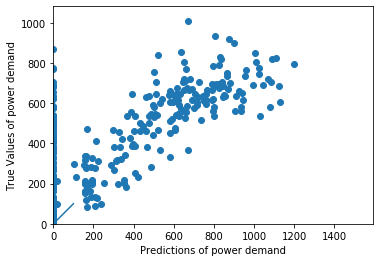

In [105]:
general_predictions = model.predict(predict_dataset).flatten()

if enable_logs == True:
    plt.scatter(exp(predict_labels), exp(general_predictions))
else:
    plt.scatter(predict_labels, general_predictions)
plt.ylabel('True Values of power demand')
plt.xlabel('Predictions of power demand')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100]);

In [106]:
if enable_logs == True:
    dummy_res = pd.concat([
        pd.Series(exp(general_predictions), name = 'pred', index = predict_labels.index),
        pd.Series(exp(predict_labels), name = 'real', index = predict_labels.index)
    ], axis = 1)#.iloc[:200].plot(figsize = (20,10))
else:
    dummy_res = pd.concat([
        pd.Series(general_predictions, name = 'pred', index = predict_labels.index),
        pd.Series(predict_labels, name = 'real', index = predict_labels.index)
    ], axis = 1)#.iloc[:200].plot(figsize = (20,10))

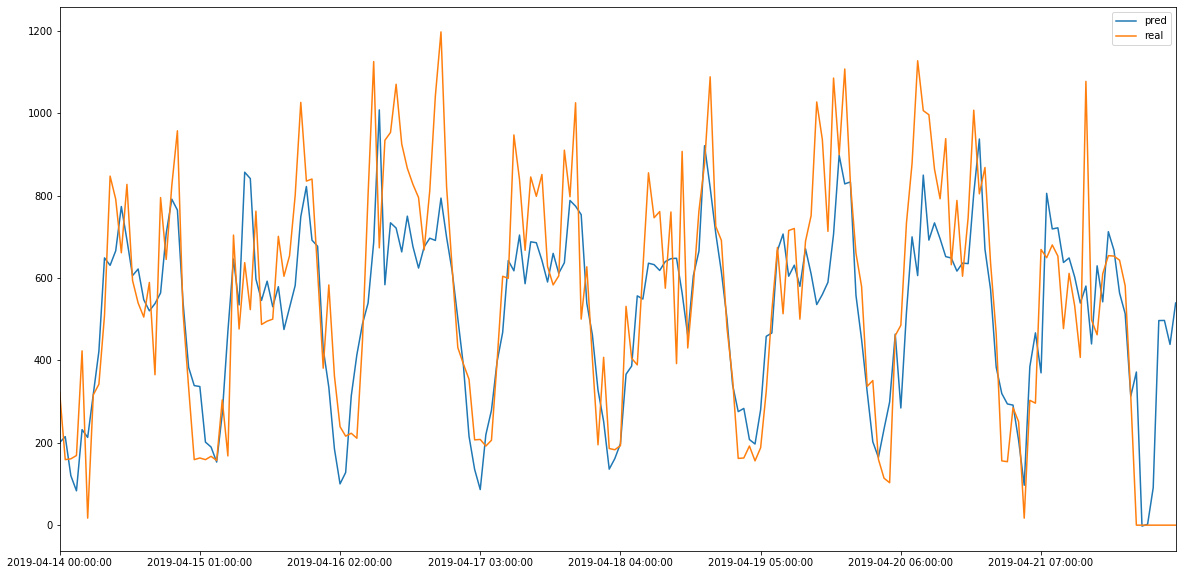

In [107]:
dummy_res.iloc[:200].plot(figsize = (20,10))

## Iterative prediction

In [108]:
# Create dict with lag numbers and indexes so we will now which values we have to replace
lag_dict = {int(x.replace('lag_', '')):i for i, x in enumerate(predict_dataset.columns) if 'lag' in x}

In [109]:
lag_dict

{1: 50, 2: 51, 3: 52, 4: 53}

In [110]:
# Prepare container with first y values so the first next record can have previos values of y to fill in
Y_queue = list(train_labels.iloc[-5:].values)

In [111]:
Y_queue

[739.0, 889.0, 971.0, 480.0, 442.0]

In [112]:
import numpy as np

In [113]:
# So, for the first record in week_to_predict (and first record after those ones with 'static' log_x values)
every_day_train_container = []
every_day_label_container = []
for i, next_record in enumerate(predict_dataset.values):
    # Copy features to tmp container
    tmp_features_conatiner = next_record
    # For log type present in features
    for log_number, log_index in lag_dict.items():
        # Take previous predicted value
        lag_val = Y_queue[-log_number]
        # And replace with it current (kind of false) log value
        tmp_features_conatiner[log_index] = lag_val
    # Predict on updated row
    y_pred = model.predict(np.array([tmp_features_conatiner]))
    # Append prediction to queue
    Y_queue.append(y_pred[0][0])
    
    # If it is still week where we have real values update model
    if predict_labels[i] != 0:
    
        # append to tmp container to be able to train every 24h easily
        every_day_train_container.append(np.array([next_record]))
        every_day_label_container.append(predict_labels[i])

# remove first 5 real values
Y_queue = Y_queue[5:]

In [114]:
res = pd.concat([
    predict_labels,
    pd.Series(Y_queue, index = predict_labels.index, name = 'model_values')
], axis = 1)

In [115]:
res.loc[res['cleaned_power_demand'] == 0 ,'week'] = 'second'
res.loc[res['week'].isna(), 'week'] = 'first'

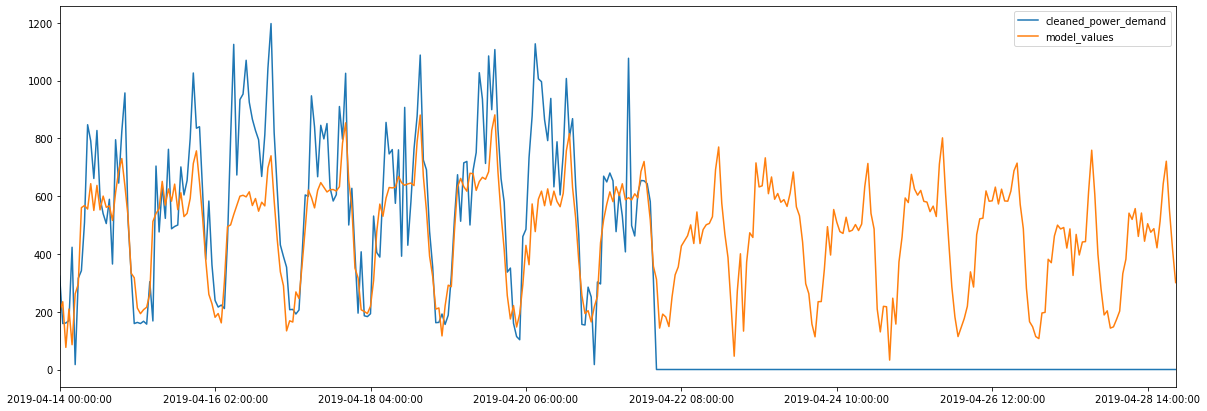

In [118]:
res.plot(figsize = (20, 7))

In [119]:
res['err'] = (abs(res['cleaned_power_demand'] - res['model_values']) ** 2) ** (1/2)

In [120]:
# RMSE dla ostatniego tygodnia gdzie mamy dane, 
# (czyli okres w którym jako lagi wstawiamy predykcje)
# (czyli to po lewej)
res[res['cleaned_power_demand'] != 0]['err'].mean()

141.8765241119033